**Measuring Bias in regression**

In [ ]:
!pip install holisticai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.8/272.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
# Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

Student dataset.

The goal of this dataset is the prediction of the numerical attribute 'G3' (mathematics grade of student in 3rd trimester).

There are a number of sensitive attributes in this dataset, some of which are : sex, address, Mjob (mother's job), Fjob (father's job)...

In [ ]:
from holisticai.datasets import load_student
df = load_student()['frame']
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [ ]:
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

**Data Exploration**

<Axes: >

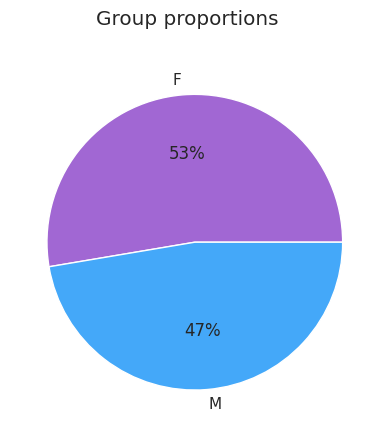

In [ ]:
from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import distribution_plot
from holisticai.bias.plots import success_rate_curves
group_pie_plot(df['sex'])

<Axes: xlabel='G3', ylabel='Density'>

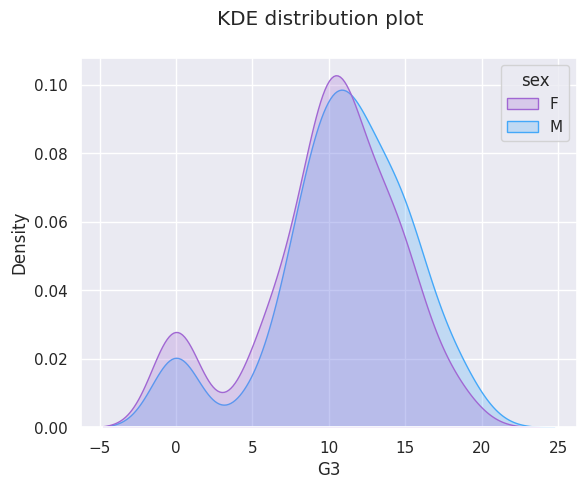

In [ ]:
# distribution of grades for male an female
distribution_plot(df['G3'], df['sex'])

The grades are fairly similar for both sex subgroups, showing a slight difference with density of male grades in the 12 to 20 range being higher.

<Axes: xlabel='G3', ylabel='Density'>

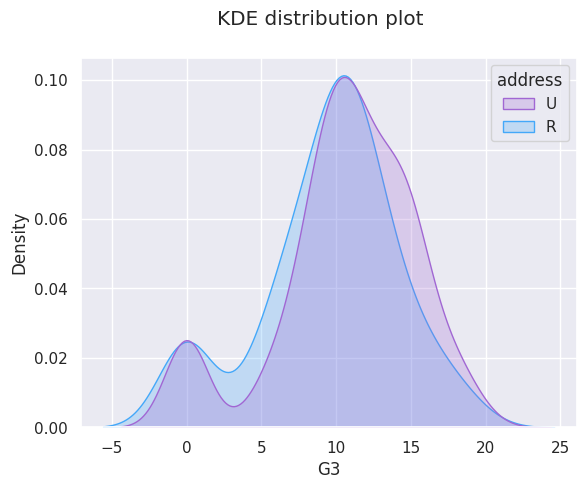

In [ ]:
# distribution of grades for urban and rural
distribution_plot(df['G3'], df['address'])

The distributions for different addresses (Urban vs Rural) show more difference, with Rural grades having higher density at lower grades.

<Axes: xlabel='G3', ylabel='Density'>

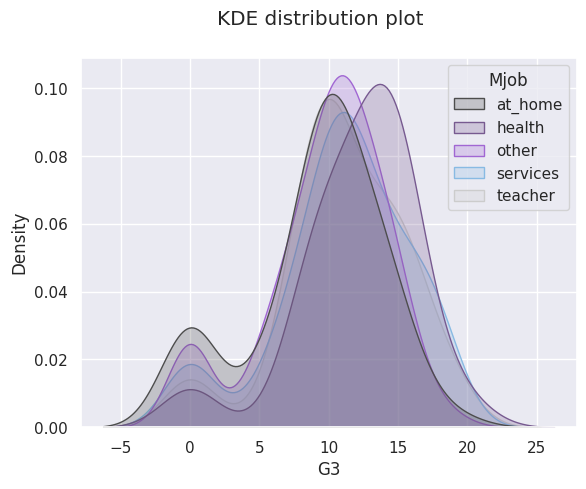

In [ ]:
# distribution of grades for different Mother jobs
distribution_plot(df['G3'], df['Mjob'])

The Mother's job attribute is the one that shows most difference in the densities of grades. For instance we observe students with a mother working in health have higher density at higher grades.

<Axes: xlabel='Score'>

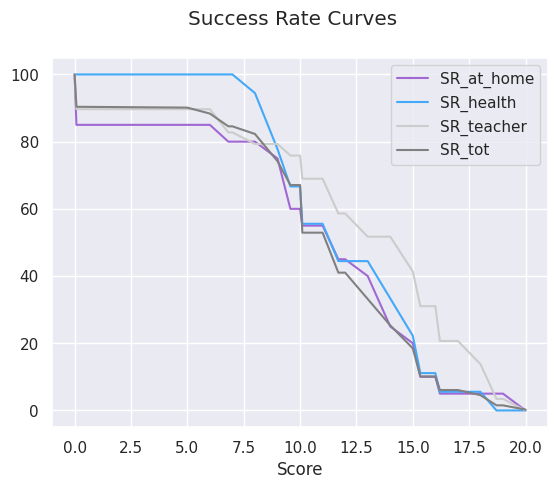

In [ ]:
p_attr = np.array(df['Fjob'])
y =      np.array(df['G3'])
success_rate_curves(p_attr, y, groups=['at_home', 'health', 'teacher'])

The above shows the success rate as a function of threshold for different subgroups of the population : Father's job in ['at_home', 'health', 'teacher']. We can observe that student's with a parent as a teacher are more likely to exceed high thresholds than other groups.

**Preprocess Data and Train a model**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
# we don't want to encode protected attributes
protected_attributes = ['sex', 'address', 'Mjob', 'Fjob']
label_attributes = ['G3', 'G2', 'G1']

# preprocess categorical columns
def preprocess_data(data, protected_attributes, label_attributes):
    categoricals = []
    for col in data.columns:
        if col not in protected_attributes and col not in label_attributes and data[col].dtype == object:
            categoricals.append(col)

    cat_encoder = OneHotEncoder()
    enc = cat_encoder.fit_transform(data[categoricals])
    enc = pd.DataFrame(enc.toarray())
    df = pd.concat([data,enc],axis=1).drop(columns=categoricals) # add encoded columns

    df = df.rename(str, axis='columns')
    return df
# Load, preprocess and split for training
data = df
preproc_data = preprocess_data(data, protected_attributes, label_attributes)
train, test = train_test_split(preproc_data, test_size=0.3, random_state=42)
# G3 is the students final grade (drop G2 and G1 as well because highly correlated with G3)
X_train = train.drop(columns=label_attributes)
X_test = test.drop(columns=label_attributes)
y_train = train['G3']
y_test = test['G3']

# Train a simple linear regression model
LR = LinearRegression()
model = LR.fit(X_train.drop(columns=protected_attributes), y_train)

# Predict values
y_pred = model.predict(X_test.drop(columns=protected_attributes))
from holisticai.efficacy.metrics import regression_efficacy_metrics

regression_efficacy_metrics(y_pred, y_test)

,Value,Reference
Metric,,
RMSE,4.368238,0
MAE,3.479682,0
MAPE,0.371434,0
Max Error,11.445225,0
SMAPE,0.212678,0


**Measure bias**

In [ ]:
# import some bias metrics
from holisticai.bias.metrics import statistical_parity_regression
from holisticai.bias.metrics import disparate_impact_regression
from holisticai.bias.metrics import mae_ratio
from holisticai.bias.metrics import rmse_ratio
# set up vectors for gender

group_a = np.array(X_test['sex']=='M')
group_b = np.array(X_test['sex']=='F')
y_pred  = np.array(model.predict(X_test.drop(columns=protected_attributes)))
y_true  = np.array(y_test)
# evaluate fairness metrics for gender
print ('Statistical Parity Q80   : ' + str(statistical_parity_regression(group_a, group_b, y_pred, q=0.8)))
print ('Disparate Impact Q80     : ' + str(disparate_impact_regression(group_a, group_b, y_pred, q=0.8)))
print ('MAE Ratio                : ' + str(mae_ratio(group_a, group_b, y_pred, y_true)))
print ('RMSE Ratio               : ' + str(rmse_ratio(group_a, group_b, y_pred, y_true)))

Statistical Parity Q80   : 0.02345958168456755
Disparate Impact Q80     : 1.1236959761549925
MAE Ratio                : 0.9140575495574778
RMSE Ratio               : 0.8663008597756455


All the above metrics are within acceptable ranges. This shows there isn't much bias for the subgroups of the sex column. Let's try the address attribute.

In [ ]:
# set up vectors for address

group_a = np.array(X_test['address']=='U')
group_b = np.array(X_test['address']=='R')
y_pred  = np.array(model.predict(X_test.drop(columns=protected_attributes)))
y_true  = np.array(y_test)

In [ ]:
# set up vectors for address

group_a = np.array(X_test['address']=='U')
group_b = np.array(X_test['address']=='R')
y_pred  = np.array(model.predict(X_test.drop(columns=protected_attributes)))
y_true  = np.array(y_test)
# evaluate fairness metrics for address
print ('Statistical Parity Q80   : ' + str(statistical_parity_regression(group_a, group_b, y_pred, q=0.8)))
print ('Disparate Impact Q80     : ' + str(disparate_impact_regression(group_a, group_b, y_pred, q=0.8)))
print ('MAE Ratio                : ' + str(mae_ratio(group_a, group_b, y_pred, y_true)))
print ('RMSE Ratio               : ' + str(rmse_ratio(group_a, group_b, y_pred, y_true)))

Statistical Parity Q80   : 0.10488505747126436
Disparate Impact Q80     : 1.839080459770115
MAE Ratio                : 0.9036149960946053
RMSE Ratio               : 0.9325686271190994


The disparate impact at quantile 0.8 is outside of fair ranges (0.8, 1.2), students living in urban areas are 1.8 times more likely to be predicted in top 20% of grades than students living in rural areas.

**Equality of outcome metrics (batch computation)**

In [ ]:
# set up vectors for address

group_a = np.array(X_test['address']=='U')
group_b = np.array(X_test['address']=='R')
y_pred  = np.array(model.predict(X_test.drop(columns=protected_attributes)))
from holisticai.bias.metrics import regression_bias_metrics
regression_bias_metrics(group_a, group_b, y_pred, metric_type='equal_outcome')

,Value,Reference
Metric,,
Disparate Impact Q90,1.103448,1
Disparate Impact Q80,1.839080,1
Disparate Impact Q50,1.208539,1
Statistical Parity Q50,0.104885,0
No Disparate Impact Level,13.556550,-
Average Score Difference,0.618790,0
Average Score Ratio,1.061142,1
Z Score Difference,0.274944,0
Max Statistical Parity,0.206178,0


**Equality of opportunity metrics (batch computation)**

In [ ]:
# set up vectors for address

group_a = X_test['address']=='U'
group_b = X_test['address']=='R'
y_pred  = model.predict(X_test.drop(columns=protected_attributes))
y_true  = y_test
regression_bias_metrics(group_a, group_b, y_pred, y_true, metric_type='equal_opportunity')

,Value,Reference
Metric,,
RMSE Ratio,0.932569,1
RMSE Ratio Q80,0.818769,1
MAE Ratio,0.903615,1
MAE Ratio Q80,0.756548,1
Correlation Difference,0.215157,0


**Bias measuring and mitigation in regression tasks**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from holisticai.datasets import load_us_crime
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

Dataset : "Communities and Crime" dataset.

This dataset contains demographic variables such as population size, race, and education level, as well as variables related to law enforcement.

The objective is to predict the crime rate per capita in each community.

In [ ]:
dataset = load_us_crime(return_X_y=False, as_frame=True)
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8.0,NaN,NaN,Lakewoodcity,1.0,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53.0,NaN,NaN,Tukwilacity,1.0,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24.0,NaN,NaN,Aberdeentown,1.0,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34.0,5.0,81440.0,Willingborotownship,1.0,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42.0,95.0,6096.0,Bethlehemtownship,1.0,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [ ]:
df.describe()

,state,county,community,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
count,1994.000000,820.000000,817.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,319.000000,319.000000,319.000000,319.000000,1994.000000,319.000000,1994.000000
mean,28.683551,58.826829,46188.336597,5.493982,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,...,0.065231,0.232854,0.161685,0.163103,0.076708,0.698589,0.440439,0.094052,0.195078,0.237979
std,16.397553,126.420560,25299.726569,2.873694,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,...,0.109459,0.203092,0.229055,0.214778,0.140207,0.213944,0.405808,0.240328,0.164718,0.232985
min,1.000000,1.000000,70.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,9.000000,25065.000000,3.000000,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,...,0.020000,0.100000,0.020000,0.040000,0.020000,0.620000,0.000000,0.000000,0.110000,0.070000
50%,34.000000,23.000000,48090.000000,5.000000,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,...,0.040000,0.170000,0.070000,0.080000,0.030000,0.750000,0.500000,0.000000,0.150000,0.150000
75%,42.000000,59.500000,66660.000000,8.000000,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,...,0.070000,0.280000,0.190000,0.195000,0.060000,0.840000,1.000000,0.000000,0.220000,0.330000
max,56.000000,840.000000,94597.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.isna().sum(), df.shape

(state                     0
 county                 1174
 community              1177
 communityname             0
 fold                      0
                        ... 
 LemasPctPolicOnPatr    1675
 LemasGangUnitDeploy    1675
 LemasPctOfficDrugUn       0
 PolicBudgPerPop        1675
 ViolentCrimesPerPop       0
 Length: 128, dtype: int64,
 (1994, 128))

In [ ]:
def preprocess_us_crime_dataset(df, protected_feature):
  """Performs the pre-processing step of the data."""
  # Remove NaN elements from dataframe
  df_ = df.copy()
  df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
  df_clean = df_clean.dropna()
  # Get the protected attribute vectors
  group_a = df_clean[protected_feature].apply(lambda x: x>0.5)
  group_b =  1-group_a
  group_b = group_b.astype('bool')
  # Remove unnecessary columns
  cols = [c for c in df_clean.columns if (not c.startswith('race')) and (not c.startswith('age'))]
  df_clean = df_clean[cols].iloc[:,3:]
  return df_clean, group_a, group_b

In [ ]:
df_clean, group_a, group_b = preprocess_us_crime_dataset(df, 'racePctWhite')
df.shape, df_clean.shape

((1994, 128), (1993, 93))

**Data analysis**

<Axes: >

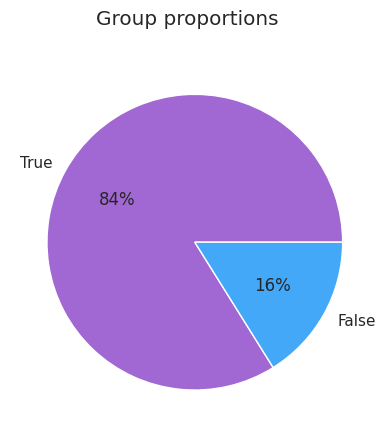

In [ ]:
from holisticai.bias.plots import group_pie_plot

group_pie_plot(group_a)

This graph show us that the proportion of white people (labelled as True) is very high compared to the remain races.

In [ ]:
X = df_clean.values[:,:-1]
y = df_clean.values[:,-1]

X.shape, y.shape

((1993, 92), (1993,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)
train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

**Model training**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from holisticai.pipeline import Pipeline
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train a simple linear regression model
LR = LinearRegression()
model = LR.fit(X, y)

X, y, group_a, group_b = test_data

X = scaler.transform(X)

# Predict values
y_pred = model.predict(X)

baseline_rmse = mean_squared_error(y, y_pred, squared=False)
print("RMS error: {}".format(baseline_rmse))

RMS error: 0.13876591590852652


**Bias measuring**

regression_bias_metrics function allows us to select which metrics we want to calculate, if equal_outcome, equal_opportunity or both, where equal_outcome shows how disadvantaged groups are treated by the model and equal_opportunity shows if all the groups have the same opportunities.

In [ ]:
from holisticai.bias.metrics import regression_bias_metrics
df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
y_baseline = y_pred.copy()
df_baseline=df.copy()
df_baseline

,Value,Reference
Metric,,
Disparate Impact Q90,0.016953,1
Disparate Impact Q80,0.100673,1
Disparate Impact Q50,0.424518,1
Statistical Parity Q50,-0.703821,0
No Disparate Impact Level,0.045669,-
Average Score Difference,-0.347758,0
Average Score Ratio,0.320391,1
Z Score Difference,-2.465747,0
Max Statistical Parity,0.768248,0


**Disparate Impact Q:** Shows the ratio of success rates between the protected groups for a certain quantile. Values below 1 are unfair towards group_a. Values above 1 are unfair towards group_b. The range (0.8, 1.2) is considered acceptable.

**Statistical parity :** Computes the difference of success rates between the protected groups. Values below 0 are considered unfair towards group_a while values above 0 are considered unfair towards group_b.

**Average score difference :** Computes the difference in average scores between the protected groups. Negative values indicate the group_a has lower average score, so bias against group_a, while positive values indicate group_b has lower average score, so bias against group_b.

**Z score difference :** Computes the spread in Zscores between the protected groups, the Zscore is a normalised version of Disparate Impact.

**Max Statistical Parity :** Computes the maximum over all thresholds of the absolute statistical parity between the protected groups, values below 0.1 in absolute value are considered acceptable.

**RMSE ratio :** Computes the RMSE for the protected groups, lower values show bias against group_a while higher values show bias against group_b.

**MAE ratio :** Similar to the previous metric, computes the MAE for the protected groups, lower values show bias against group_a while higher values show bias against group_b.

**Correlation difference :** Computes the difference in correlation between predictions and targets for the protected groups, positive values show bias against group_a while negative values show bias against group_b.

**Bias mitigation**

**a. Preprocessing - Correlation remover**

"Correlation remover" method is a preprocessing algorithm that changes the original dataset by removing all correlation with sensitive values applying a linear transformation to the non-sensitive feature columns of the dataset.

**Traditional implementation**

In [ ]:
from holisticai.bias.mitigation import CorrelationRemover
model = LinearRegression()
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

corr = CorrelationRemover()
test = corr.fit_transform(X, group_a, group_b)

model.fit(test, y)

X, y, group_a, group_b = test_data

X = scaler.transform(X)

test = corr.transform(X, group_a, group_b)

y_pred = model.predict(test)

df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_correm =df.copy()
df_correm

,Value,Reference
Metric,,
Disparate Impact Q90,0.209091,1
Disparate Impact Q80,0.219814,1
Disparate Impact Q50,0.499692,1
Statistical Parity Q50,-0.440975,0
No Disparate Impact Level,0.060019,-
Average Score Difference,-0.219764,0
Average Score Ratio,0.450649,1
Z Score Difference,-1.388035,0
Max Statistical Parity,0.529644,0


In [ ]:
correm_rmse = mean_squared_error(y, y_pred, squared=False)
print("RMS error: {}".format(correm_rmse))

RMS error: 0.1498739685977158


**Pipeline implementation**

In [ ]:
model = LinearRegression()
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", CorrelationRemover()),
        ("model", model),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)
df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_correm_w_p =df.copy()
df_correm_w_p

,Value,Reference
Metric,,
Disparate Impact Q90,0.209091,1
Disparate Impact Q80,0.219814,1
Disparate Impact Q50,0.499692,1
Statistical Parity Q50,-0.440975,0
No Disparate Impact Level,0.060019,-
Average Score Difference,-0.219764,0
Average Score Ratio,0.450649,1
Z Score Difference,-1.388035,0
Max Statistical Parity,0.529644,0


**Results comparison**

In [ ]:
result = pd.concat([df_baseline, df_correm, df_correm_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Disparate Impact Q90,0.016953,0.209091,0.209091,1
Disparate Impact Q80,0.100673,0.219814,0.219814,1
Disparate Impact Q50,0.424518,0.499692,0.499692,1
Statistical Parity Q50,-0.703821,-0.440975,-0.440975,0
No Disparate Impact Level,0.045669,0.060019,0.060019,-
Average Score Difference,-0.347758,-0.219764,-0.219764,0
Average Score Ratio,0.320391,0.450649,0.450649,1
Z Score Difference,-2.465747,-1.388035,-1.388035,0
Max Statistical Parity,0.768248,0.529644,0.529644,0


alpha value which is a parameter to control how much to filter, for alpha=1.0 is filtered out all information while for alpha=0.0 it is not applied any.

In [ ]:
def calculate_metrics(train_data, test_data, group_a, group_b, alpha, metrics_cols):
  model = LinearRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", CorrelationRemover(alpha=alpha)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  df = regression_bias_metrics(
      group_a,
      group_b,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      alpha,
      mean_squared_error(y, y_pred, squared=False)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics
metrics_val = []
metrics_cols = ['Disparate Impact Q80', 'RMSE Ratio', 'MAE Ratio', 'Statistical Parity Q50', 'Average Score Difference', 'Correlation Difference']

for alphas in np.linspace(0,1,6):
  metrics_val.append(calculate_metrics(train_data, test_data, group_a, group_b, alphas, metrics_cols))

metrics = ['alpha', 'RMSE']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,alpha,RMSE,Disparate Impact Q80,RMSE Ratio,MAE Ratio,Statistical Parity Q50,Average Score Difference,Correlation Difference
0,0.0,0.138766,0.100673,0.651463,0.557317,-0.703821,-0.347758,-0.048799
1,0.2,0.139087,0.118895,0.650107,0.567364,-0.651252,-0.333304,-0.045597
2,0.4,0.140058,0.125455,0.643450,0.568833,-0.633729,-0.314404,-0.042117
3,0.6,0.141958,0.139394,0.628591,0.566065,-0.598682,-0.289904,-0.038664
4,0.8,0.145120,0.171074,0.602901,0.546935,-0.528590,-0.258633,-0.035644
5,1.0,0.149874,0.219814,0.565712,0.512898,-0.440975,-0.219764,-0.033565


Text(0.5, 0, 'Alpha parameter')

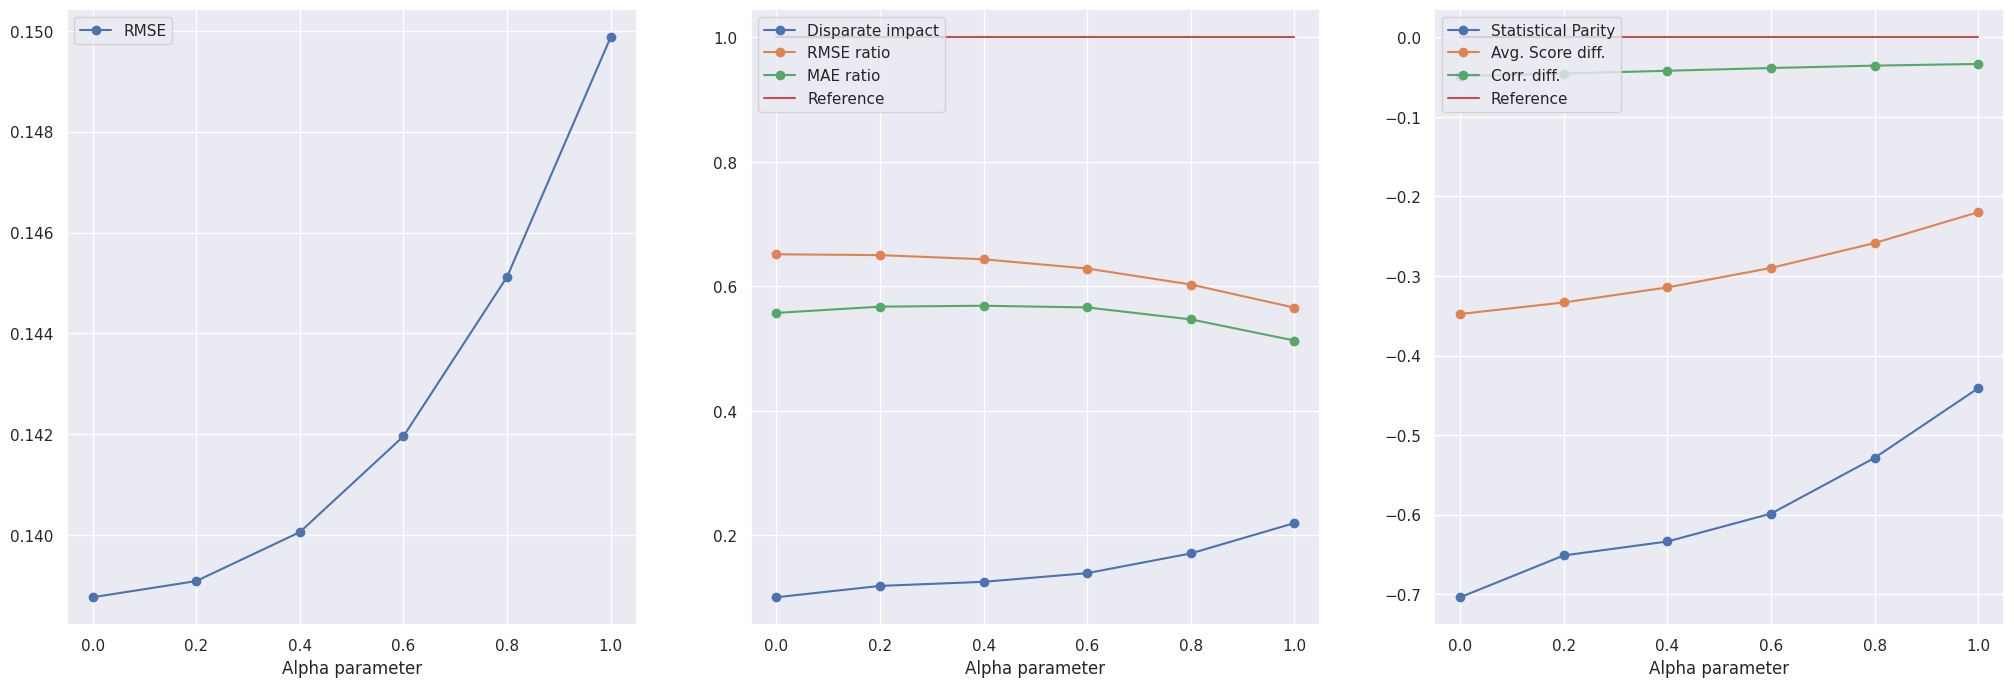

In [ ]:
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(df_metrics.alpha, df_metrics.RMSE, 'o-', label='RMSE')
plt.legend(loc='upper left')
plt.xlabel('Alpha parameter')
plt.subplot(132)
plt.plot(df_metrics.alpha, df_metrics['Disparate Impact Q80'], 'o-', label='Disparate impact')
plt.plot(df_metrics.alpha, df_metrics['RMSE Ratio'], 'o-', label='RMSE ratio')
plt.plot(df_metrics.alpha, df_metrics['MAE Ratio'], 'o-', label='MAE ratio')
plt.plot(df_metrics.alpha, np.ones_like(df_metrics['MAE Ratio']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('Alpha parameter')
plt.subplot(133)
plt.plot(df_metrics.alpha, df_metrics['Statistical Parity Q50'], 'o-', label='Statistical Parity')
plt.plot(df_metrics.alpha, df_metrics['Average Score Difference'], 'o-', label='Avg. Score diff.')
plt.plot(df_metrics.alpha, df_metrics['Correlation Difference'], 'o-', label='Corr. diff.')
plt.plot(df_metrics.alpha, np.zeros_like(df_metrics['Correlation Difference']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('Alpha parameter')

**Bias mitigation**

**b. Preprocessing method: Disparate impact remover**

"Disparate impact remover" method is a preprocessing algorithm that edits feature values to increase group fairness while preserving rank-ordering within groups.

**Traditional implementation**

In [ ]:
from holisticai.bias.mitigation import DisparateImpactRemover

In [ ]:
model = LinearRegression()
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

corr = DisparateImpactRemover(repair_level=0.0)
test = corr.fit_transform(X, group_a, group_b)

model.fit(test, y)

X, y, group_a, group_b = test_data

X = scaler.transform(X)

test = corr.transform(X, group_a, group_b)

y_pred = model.predict(test)

df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_disprem =df.copy()
df_disprem

,Value,Reference
Metric,,
Disparate Impact Q90,0.016953,1
Disparate Impact Q80,0.100673,1
Disparate Impact Q50,0.424518,1
Statistical Parity Q50,-0.703821,0
No Disparate Impact Level,0.045669,-
Average Score Difference,-0.347758,0
Average Score Ratio,0.320391,1
Z Score Difference,-2.465747,0
Max Statistical Parity,0.768248,0


In [ ]:
dispimp_rmse = mean_squared_error(y, y_pred, squared=False)
print("RMS error: {}".format(dispimp_rmse))

RMS error: 0.13876591590852652


**Pipeline implementation**

In [ ]:
model = LinearRegression()
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", DisparateImpactRemover()),
        ("model", model),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)
df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_disprem_w_p =df.copy()
df_disprem_w_p

,Value,Reference
Metric,,
Disparate Impact Q90,0.209091,1
Disparate Impact Q80,0.313636,1
Disparate Impact Q50,0.537662,1
Statistical Parity Q50,-0.318314,0
No Disparate Impact Level,0.156474,-
Average Score Difference,-0.155742,0
Average Score Ratio,0.613786,1
Z Score Difference,-1.116751,0
Max Statistical Parity,0.459289,0


**Results comparison**

In [ ]:
result = pd.concat([df_baseline, df_disprem, df_disprem_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result


,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Disparate Impact Q90,0.016953,0.016953,0.209091,1
Disparate Impact Q80,0.100673,0.100673,0.313636,1
Disparate Impact Q50,0.424518,0.424518,0.537662,1
Statistical Parity Q50,-0.703821,-0.703821,-0.318314,0
No Disparate Impact Level,0.045669,0.045669,0.156474,-
Average Score Difference,-0.347758,-0.347758,-0.155742,0
Average Score Ratio,0.320391,0.320391,0.613786,1
Z Score Difference,-2.465747,-2.465747,-1.116751,0
Max Statistical Parity,0.768248,0.768248,0.459289,0


repair_level value which is a parameter to control the repair amount, where 0 means no repair while 1 is full repair.

In [ ]:
def calculate_metrics(train_data, test_data, group_a, group_b, repair_level, metrics_cols):
  model = LinearRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", DisparateImpactRemover(repair_level=repair_level)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  df = regression_bias_metrics(
      group_a,
      group_b,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      repair_level,
      mean_squared_error(y, y_pred, squared=False)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics
metrics_val = []
metrics_cols = ['Disparate Impact Q80', 'RMSE Ratio', 'MAE Ratio', 'Statistical Parity Q50', 'Average Score Difference', 'Correlation Difference']

for repair_values in np.linspace(0,1,6):
  metrics_val.append(calculate_metrics(train_data, test_data, group_a, group_b, repair_values, metrics_cols))

metrics = ['repair_level', 'RMSE']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,repair_level,RMSE,Disparate Impact Q80,RMSE Ratio,MAE Ratio,Statistical Parity Q50,Average Score Difference,Correlation Difference
0,0.0,0.138766,0.100673,0.651463,0.557317,-0.703821,-0.347758,-0.048799
1,0.2,0.139598,0.132282,0.648453,0.589066,-0.616206,-0.305940,-0.047567
2,0.4,0.144251,0.162626,0.647840,0.634182,-0.546113,-0.257579,-0.039191
3,0.6,0.148842,0.179915,0.638538,0.644633,-0.511067,-0.224603,-0.039413
4,0.8,0.156219,0.242998,0.641506,0.672920,-0.405929,-0.190294,-0.030888
5,1.0,0.165536,0.313636,0.655500,0.706106,-0.318314,-0.155742,-0.030465


Text(0.5, 0, 'Repair level')

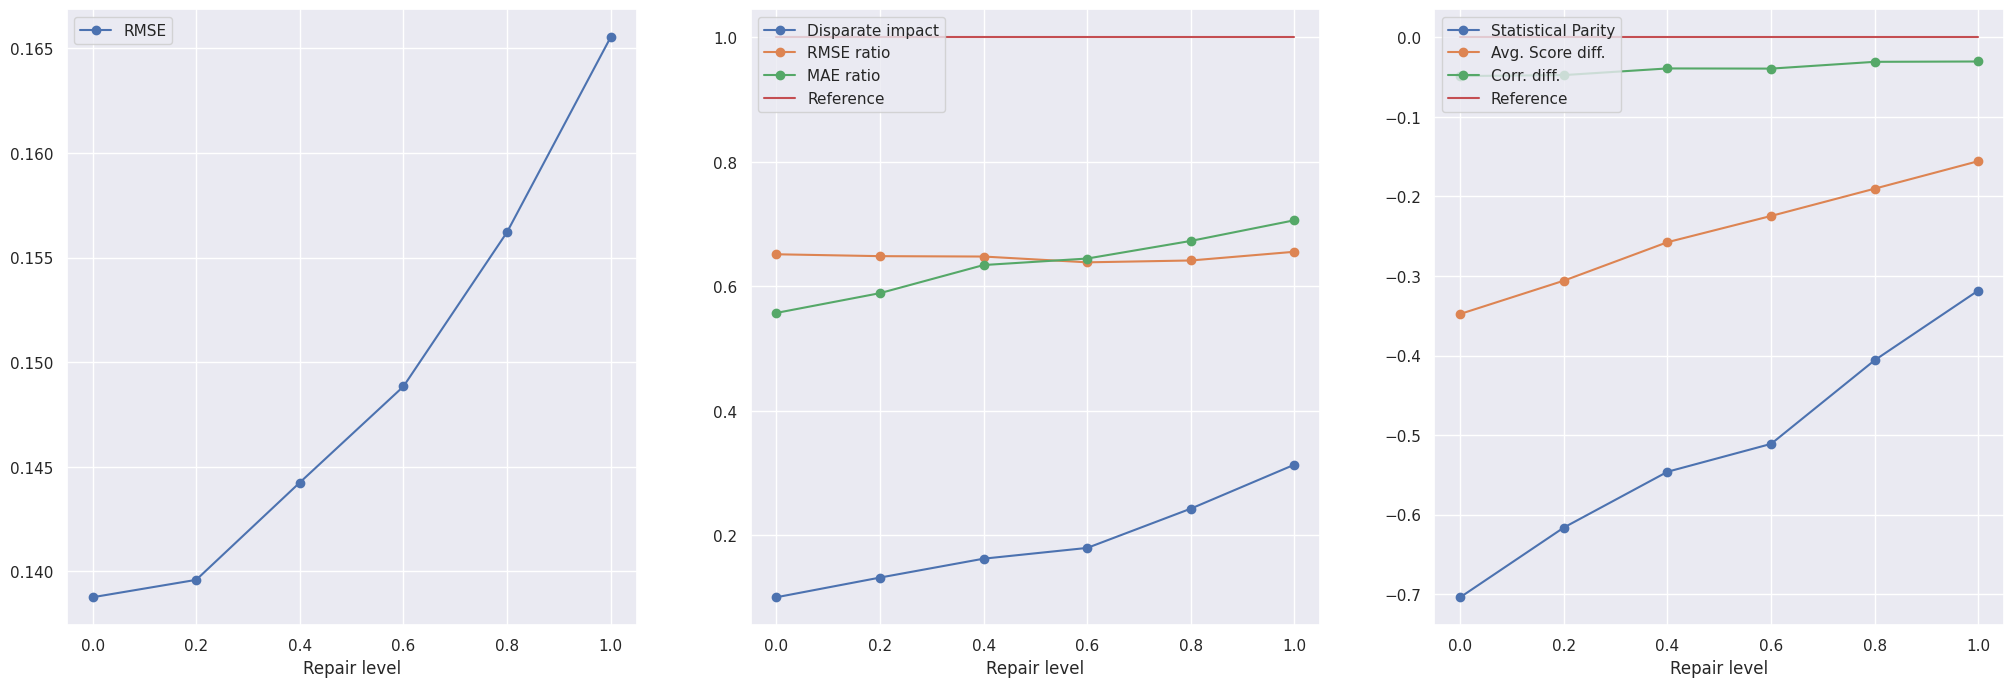

In [ ]:
x_axis = df_metrics.repair_level
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics.RMSE, 'o-', label='RMSE')
plt.legend(loc='upper left')
plt.xlabel('Repair level')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Disparate Impact Q80'], 'o-', label='Disparate impact')
plt.plot(x_axis, df_metrics['RMSE Ratio'], 'o-', label='RMSE ratio')
plt.plot(x_axis, df_metrics['MAE Ratio'], 'o-', label='MAE ratio')
plt.plot(x_axis, np.ones_like(df_metrics['MAE Ratio']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('Repair level')
plt.subplot(133)
plt.plot(x_axis, df_metrics['Statistical Parity Q50'], 'o-', label='Statistical Parity')
plt.plot(x_axis, df_metrics['Average Score Difference'], 'o-', label='Avg. Score diff.')
plt.plot(x_axis, df_metrics['Correlation Difference'], 'o-', label='Corr. diff.')
plt.plot(x_axis, np.zeros_like(df_metrics['Correlation Difference']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('Repair level')

as the repair_value parameter increases, we get a better model in terms of fairness, but the RMSE value will be increased.

**Dataset:** Insurance

In [ ]:
df=pd.read_csv("/content/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.isnull().sum(), df.shape

(age         0
 sex         0
 bmi         0
 children    0
 smoker      0
 region      0
 charges     0
 dtype: int64,
 (1338, 7))

In [ ]:
df["children"].unique()

array([0, 1, 3, 2, 5, 4])

In [ ]:
def preprocess_insurance_dataset(df):
  """Performs the pre-processing step of the data."""
  # Remove NaN elements from dataframe
  df_ = df.copy()
  df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
  df_clean = df_clean.dropna()
  # Get the protected attribute vectors
  group_a = df_clean["sex"] == "female"
  group_b = df_clean["sex"] == "male"

  group_a = np.squeeze(group_a.values)
  group_b = np.squeeze(group_b.values)
  # Remove unnecessary columns
  tmp = pd.get_dummies(df_clean.drop(columns=["sex", "charges"]))
  df_clean = pd.concat([tmp, df_clean["charges"].astype("uint8")], axis=1)
  return df_clean, group_a, group_b

In [ ]:
df_clean, group_a, group_b = preprocess_insurance_dataset(df)
df.shape, df_clean.shape

((1338, 7), (1338, 10))

In [ ]:
df_clean.head()

,age,bmi,children,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges
0,19,27.900,0,0,1,0,0,0,1,244
1,18,33.770,1,1,0,0,0,1,0,189
2,28,33.000,3,1,0,0,0,1,0,97
3,33,22.705,0,1,0,0,1,0,0,224
4,32,28.880,0,1,0,0,1,0,0,26


<Axes: >

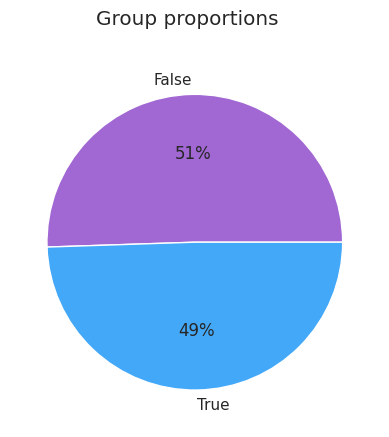

In [ ]:
from holisticai.bias.plots import group_pie_plot

group_pie_plot(group_a)

In [ ]:
X = df_clean.values[:,:-1]
y = df_clean.values[:,-1]

X.shape, y.shape

((1338, 9), (1338,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)
train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from holisticai.pipeline import Pipeline
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train a simple linear regression model
LR = LinearRegression()
model = LR.fit(X, y)

X, y, group_a, group_b = test_data

X = scaler.transform(X)

# Predict values
y_pred = model.predict(X)

baseline_rmse = mean_squared_error(y, y_pred, squared=False)
print("RMS error: {}".format(baseline_rmse))

RMS error: 68.40243090743182


In [ ]:
from holisticai.bias.metrics import regression_bias_metrics
df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
y_baseline = y_pred.copy()
df_baseline=df.copy()
df_baseline

,Value,Reference
Metric,,
Disparate Impact Q90,0.685714,1
Disparate Impact Q80,1.232298,1
Disparate Impact Q50,1.030385,1
Statistical Parity Q50,0.041741,0
No Disparate Impact Level,147.753459,-
Average Score Difference,0.416670,0
Average Score Ratio,1.003222,1
Z Score Difference,0.055071,0
Max Statistical Parity,0.068080,0


**Preprocessing - Correlation remover**

In [ ]:
from holisticai.bias.mitigation import CorrelationRemover
model = LinearRegression()
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

corr = CorrelationRemover()
test = corr.fit_transform(X, group_a, group_b)

model.fit(test, y)

X, y, group_a, group_b = test_data

X = scaler.transform(X)

test = corr.transform(X, group_a, group_b)

y_pred = model.predict(test)

df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_correm =df.copy()
df_correm

,Value,Reference
Metric,,
Disparate Impact Q90,0.984615,1
Disparate Impact Q80,1.060571,1
Disparate Impact Q50,0.941991,1
Statistical Parity Q50,0.011830,0
No Disparate Impact Level,142.340494,-
Average Score Difference,0.156351,0
Average Score Ratio,1.001210,1
Z Score Difference,0.023387,0
Max Statistical Parity,0.063393,0


In [ ]:
correm_rmse = mean_squared_error(y, y_pred, squared=False)
print("RMS error: {}".format(correm_rmse))

RMS error: 68.26670037089764


In [ ]:
model = LinearRegression()
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", CorrelationRemover()),
        ("model", model),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)
df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_correm_w_p =df.copy()
df_correm_w_p

,Value,Reference
Metric,,
Disparate Impact Q90,0.984615,1
Disparate Impact Q80,1.060571,1
Disparate Impact Q50,0.941991,1
Statistical Parity Q50,0.011830,0
No Disparate Impact Level,142.340494,-
Average Score Difference,0.156351,0
Average Score Ratio,1.001210,1
Z Score Difference,0.023387,0
Max Statistical Parity,0.063393,0


In [ ]:
result = pd.concat([df_baseline, df_correm, df_correm_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Disparate Impact Q90,0.685714,0.984615,0.984615,1
Disparate Impact Q80,1.232298,1.060571,1.060571,1
Disparate Impact Q50,1.030385,0.941991,0.941991,1
Statistical Parity Q50,0.041741,0.011830,0.011830,0
No Disparate Impact Level,147.753459,142.340494,142.340494,-
Average Score Difference,0.416670,0.156351,0.156351,0
Average Score Ratio,1.003222,1.001210,1.001210,1
Z Score Difference,0.055071,0.023387,0.023387,0
Max Statistical Parity,0.068080,0.063393,0.063393,0


In [ ]:
def calculate_metrics(train_data, test_data, group_a, group_b, alpha, metrics_cols):
  model = LinearRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", CorrelationRemover(alpha=alpha)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  df = regression_bias_metrics(
      group_a,
      group_b,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      alpha,
      mean_squared_error(y, y_pred, squared=False)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics
metrics_val = []
metrics_cols = ['Disparate Impact Q80', 'RMSE Ratio', 'MAE Ratio', 'Statistical Parity Q50', 'Average Score Difference', 'Correlation Difference']

for alphas in np.linspace(0,1,6):
  metrics_val.append(calculate_metrics(train_data, test_data, group_a, group_b, alphas, metrics_cols))

metrics = ['alpha', 'RMSE']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,alpha,RMSE,Disparate Impact Q80,RMSE Ratio,MAE Ratio,Statistical Parity Q50,Average Score Difference,Correlation Difference
0,0.0,68.402431,1.232298,0.939884,0.929843,0.041741,0.416670,-0.093561
1,0.2,68.249832,1.060571,0.942228,0.933142,0.011830,0.202591,-0.134184
2,0.4,68.299416,1.180952,0.944209,0.933803,0.033929,0.472523,-0.133365
3,0.6,68.361003,0.984615,0.941056,0.931924,-0.003125,0.423374,-0.114483
4,0.8,68.356231,0.984615,0.942181,0.932417,-0.003125,0.457586,-0.125862
5,1.0,68.266700,1.060571,0.941015,0.931967,0.011830,0.156351,-0.119407


Text(0.5, 0, 'Alpha parameter')

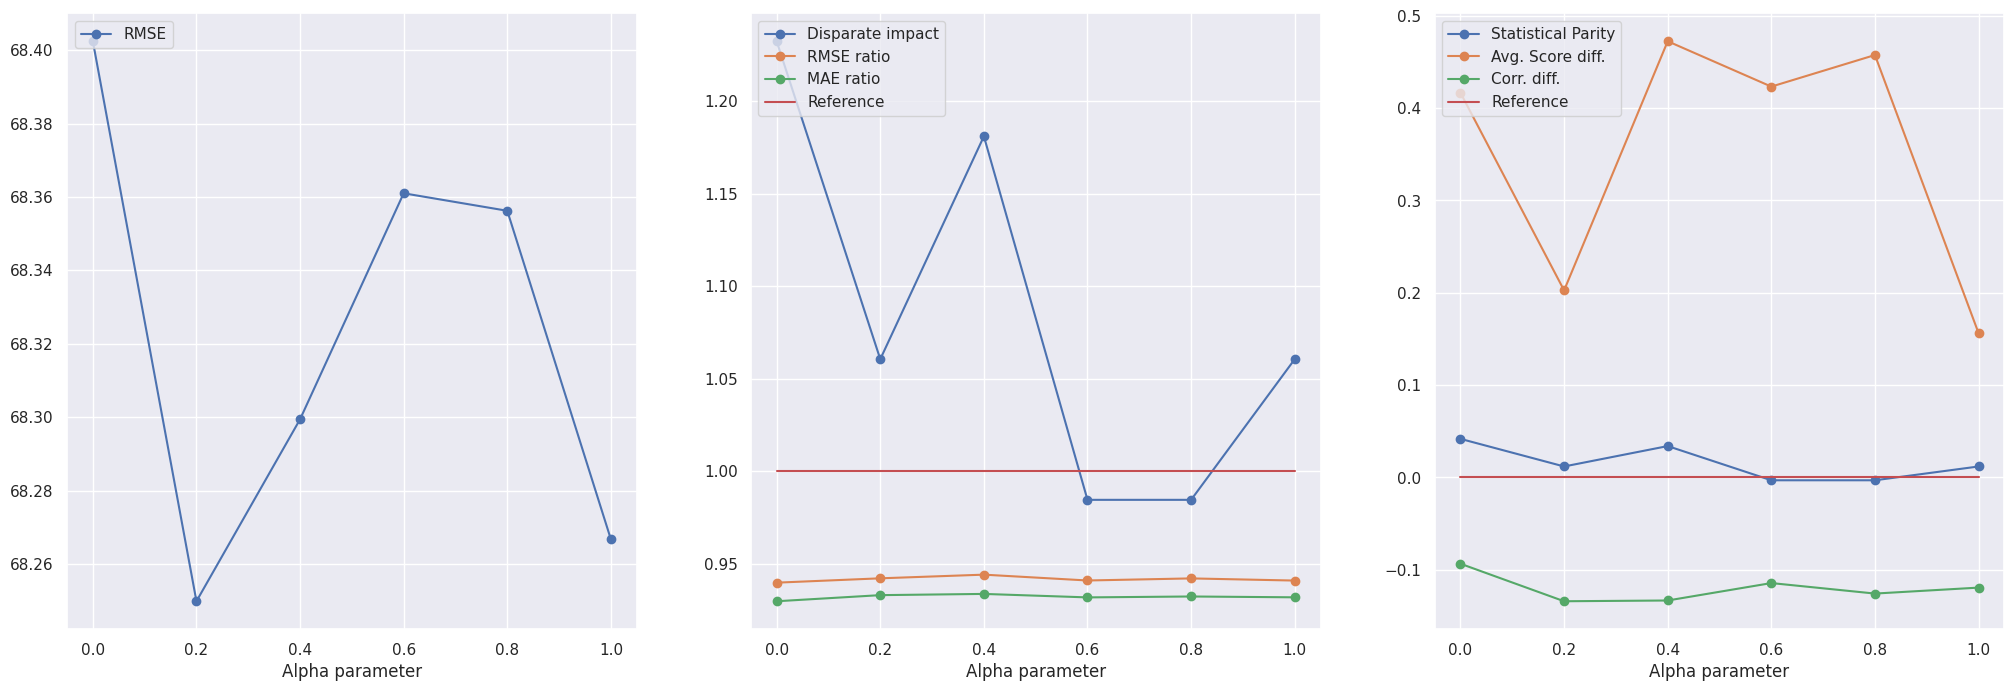

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(df_metrics.alpha, df_metrics.RMSE, 'o-', label='RMSE')
plt.legend(loc='upper left')
plt.xlabel('Alpha parameter')
plt.subplot(132)
plt.plot(df_metrics.alpha, df_metrics['Disparate Impact Q80'], 'o-', label='Disparate impact')
plt.plot(df_metrics.alpha, df_metrics['RMSE Ratio'], 'o-', label='RMSE ratio')
plt.plot(df_metrics.alpha, df_metrics['MAE Ratio'], 'o-', label='MAE ratio')
plt.plot(df_metrics.alpha, np.ones_like(df_metrics['MAE Ratio']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('Alpha parameter')
plt.subplot(133)
plt.plot(df_metrics.alpha, df_metrics['Statistical Parity Q50'], 'o-', label='Statistical Parity')
plt.plot(df_metrics.alpha, df_metrics['Average Score Difference'], 'o-', label='Avg. Score diff.')
plt.plot(df_metrics.alpha, df_metrics['Correlation Difference'], 'o-', label='Corr. diff.')
plt.plot(df_metrics.alpha, np.zeros_like(df_metrics['Correlation Difference']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('Alpha parameter')

**Preprocessing method: Disparate impact remover**

In [ ]:
from holisticai.bias.mitigation import DisparateImpactRemover

In [ ]:
model = LinearRegression()
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

corr = DisparateImpactRemover(repair_level=0.0)
test = corr.fit_transform(X, group_a, group_b)

model.fit(test, y)

X, y, group_a, group_b = test_data

X = scaler.transform(X)

test = corr.transform(X, group_a, group_b)

y_pred = model.predict(test)

df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_disprem =df.copy()
df_disprem

,Value,Reference
Metric,,
Disparate Impact Q90,0.685714,1
Disparate Impact Q80,1.232298,1
Disparate Impact Q50,1.030385,1
Statistical Parity Q50,0.041741,0
No Disparate Impact Level,147.753459,-
Average Score Difference,0.416670,0
Average Score Ratio,1.003222,1
Z Score Difference,0.055071,0
Max Statistical Parity,0.068080,0


In [ ]:
dispimp_rmse = mean_squared_error(y, y_pred, squared=False)
print("RMS error: {}".format(dispimp_rmse))

RMS error: 68.40243090743182


In [ ]:
model = LinearRegression()
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", DisparateImpactRemover()),
        ("model", model),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)
df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_disprem_w_p =df.copy()
df_disprem_w_p

,Value,Reference
Metric,,
Disparate Impact Q90,0.984615,1
Disparate Impact Q80,1.232298,1
Disparate Impact Q50,1.030385,1
Statistical Parity Q50,0.041741,0
No Disparate Impact Level,143.273961,-
Average Score Difference,0.238466,0
Average Score Ratio,1.001834,1
Z Score Difference,0.031176,0
Max Statistical Parity,0.056473,0


In [ ]:
result = pd.concat([df_baseline, df_disprem, df_disprem_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result


,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Disparate Impact Q90,0.685714,0.685714,0.984615,1
Disparate Impact Q80,1.232298,1.232298,1.232298,1
Disparate Impact Q50,1.030385,1.030385,1.030385,1
Statistical Parity Q50,0.041741,0.041741,0.041741,0
No Disparate Impact Level,147.753459,147.753459,143.273961,-
Average Score Difference,0.416670,0.416670,0.238466,0
Average Score Ratio,1.003222,1.003222,1.001834,1
Z Score Difference,0.055071,0.055071,0.031176,0
Max Statistical Parity,0.068080,0.068080,0.056473,0


In [ ]:
def calculate_metrics(train_data, test_data, group_a, group_b, repair_level, metrics_cols):
  model = LinearRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", DisparateImpactRemover(repair_level=repair_level)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  df = regression_bias_metrics(
      group_a,
      group_b,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      repair_level,
      mean_squared_error(y, y_pred, squared=False)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics
metrics_val = []
metrics_cols = ['Disparate Impact Q80', 'RMSE Ratio', 'MAE Ratio', 'Statistical Parity Q50', 'Average Score Difference', 'Correlation Difference']

for repair_values in np.linspace(0,1,6):
  metrics_val.append(calculate_metrics(train_data, test_data, group_a, group_b, repair_values, metrics_cols))

metrics = ['repair_level', 'RMSE']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,repair_level,RMSE,Disparate Impact Q80,RMSE Ratio,MAE Ratio,Statistical Parity Q50,Average Score Difference,Correlation Difference
0,0.0,68.402431,1.232298,0.939884,0.929843,0.041741,0.416670,-0.093561
1,0.2,68.112341,0.948148,0.946297,0.934825,-0.010937,0.128905,-0.160346
2,0.4,68.386406,0.914286,0.943531,0.932400,-0.018750,0.706612,-0.133728
3,0.6,68.345972,1.060571,0.943521,0.933346,0.011830,0.921085,-0.118572
4,0.8,68.566701,1.060571,0.937956,0.927764,0.011830,0.563751,-0.079724
5,1.0,68.365969,1.232298,0.938356,0.927232,0.041741,0.238466,-0.086500


Text(0.5, 0, 'Repair level')

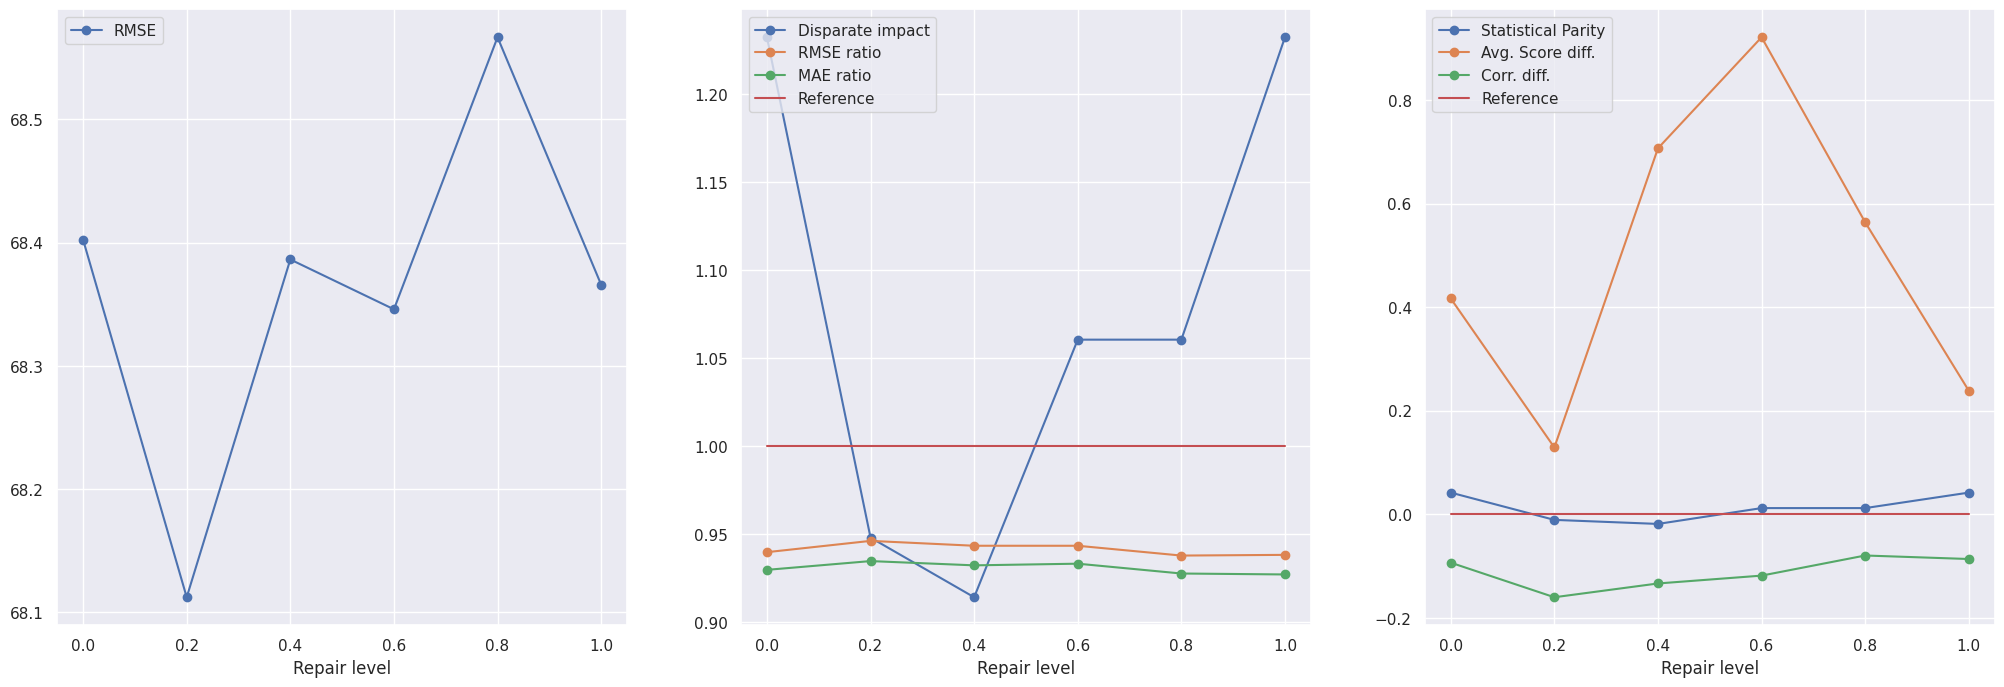

In [ ]:
x_axis = df_metrics.repair_level
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics.RMSE, 'o-', label='RMSE')
plt.legend(loc='upper left')
plt.xlabel('Repair level')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Disparate Impact Q80'], 'o-', label='Disparate impact')
plt.plot(x_axis, df_metrics['RMSE Ratio'], 'o-', label='RMSE ratio')
plt.plot(x_axis, df_metrics['MAE Ratio'], 'o-', label='MAE ratio')
plt.plot(x_axis, np.ones_like(df_metrics['MAE Ratio']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('Repair level')
plt.subplot(133)
plt.plot(x_axis, df_metrics['Statistical Parity Q50'], 'o-', label='Statistical Parity')
plt.plot(x_axis, df_metrics['Average Score Difference'], 'o-', label='Avg. Score diff.')
plt.plot(x_axis, df_metrics['Correlation Difference'], 'o-', label='Corr. diff.')
plt.plot(x_axis, np.zeros_like(df_metrics['Correlation Difference']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('Repair level')